# Week 4 Mini Project BBC News Classification

## Description of kaggle competition for BBC News Classification)

Text documents are one of the richest sources of data for businesses.

We’ll use a public dataset from the BBC comprised of 2225 articles, each labeled under one of 5 categories: business, entertainment, politics, sport or tech.

The dataset is broken into 1490 records for training and 735 for testing. The goal will be to build a system that can accurately classify previously unseen news articles into the right category.

The competition is evaluated using Accuracy as a metric.

Following blog has good information on how to look at the problem. https://cloud.google.com/blog/products/gcp/problem-solving-with-ml-automatic-document-classification

## Evaluation for submission to Kaggle
The evaluation metric for this competition is Accuracy. Sample Solution FIle shows the format required for submission. The file should contain a header and have the following two columns ArticleId (from Test File) Category (one of the five categories - sport, tech, business, entertainment or politics)

## Week 4 mini project instructions

### Step 1
Extracting word features and show Exploratory Data Analysis (EDA) — Inspect, Visualize and Clean the Data (15 pts)

Show a few visualizations like histograms. Describe any data cleaning procedures. Based on your EDA, what is your plan of analysis? 

Please feel free to look at online resources on processing raw texts to feature vectors. Many methods process texts to matrix form (word embedding), including TF-IDF, GloVe, Word2Vec, etc. Pick a method and process the raw texts to word embedding. Briefly explain the method(s) and how they work in your own words. Also, do exploratory data analysis such as word statistics and/or visualization.

As we did not learn natural language processing (NLP) specific techniques such as word embeddings in the lectures, we recommend reading discussions and example codes from others in the Kaggle and/or doing some research online to make sure you understand. You can refer to any resource as needed, but make sure you “demonstrate” your understanding- please include explaining in your own words, discussions, and your interpretation. Also importantly, please have a reference list at the end of the report. 

### Step 2
Building and training models. [35 pts]


In the Kaggle competition, the training data has labels (category). Thus, it can be solved using supervised learning. In general, the more labeled data we have, the more accurate the supervised learning model will be. But unsupervised learning can be powerful even when there is a small number of labels or no labels. This assignment will apply an unsupervised approach, especially the matrix factorization method, to discover topics in the news articles and use the labels to check the accuracy.

Here are some steps to guide this section: 
1) Think about this and answer: when you train the unsupervised model for matrix factorization, should you include texts (word features) from the test dataset or not as the input matrix? Why or why not?
2) Build a model using the matrix factorization method(s) and predict the train and test data labels. Choose any hyperparameter (e.g., number of word features) to begin with.
3) Measure the performances on predictions from both train and test datasets. You can use accuracy, confusion matrix, etc., to inspect the performance. You can get accuracy for the test data by submitting the result to Kaggle. 
4) Change hyperparameter(s) and record the results. We recommend including a summary table and/or graphs.
5) Improve the model performance if you can- some ideas may include but are not limited to; using different feature extraction methods, fit models in different subsets of data, ensemble the model prediction results, etc. 

### Step 3
Compare with supervised learning [30 pts]

Use the following steps to guide your work:

1) Pick and train a supervised learning method(s) and compare the results (train and test performance)
2) Discuss comparison with the unsupervised approach. You may try changing the train data size (e.g., Include only 10%, 20%, 50% of labels, and observe train/test performance changes). Which methods are data-efficient (require a smaller amount of data to achieve similar results)? What about overfitting?


## Part 2
Limitation(s) of sklearn’s non-negative matrix factorization library. [20 pts]

1. Load the movie ratings data (as in the HW3-recommender-system) and use matrix factorization technique(s) and predict the missing ratings from the test data. Measure the RMSE. You should use sklearn library. [10 pts]


2. Discuss the results and why sklearn's non-negative matrix facorization library did not work well compared to simple baseline or similarity-based methods we’ve done in Module 3. Can you suggest a way(s) to fix it? [10 pts]

## Importing Required Libraries

In [1]:
# importing all the required libraries
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd

import seaborn as sns

import warnings
warnings.filterwarnings("ignore")
import os
import pickle
import gzip


import re
import itertools as it

import nltk
#nltk.download('stopwords')
#nltk.download('punkt')
#nltk.download('wordnet')
import nltk.corpus
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from string import digits

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF
from sklearn.metrics import accuracy_score, confusion_matrix, mean_squared_error
import sklearn.metrics as metrics
from sklearn.model_selection import ParameterGrid, train_test_split




In [ ]:
os.getcwd()
#os.chdir("C:/Users/andreacruz/Documents/University of Colorado, Boulder MSDS/Machine Learning/Unsupervised Learning/Week 4")

## Data Loading

Let's load the data and take a look at the structure of the training and test datasets...

In [2]:
#Import data from csv file
BBC_train = pd.read_csv('BBC News Train.csv')
BBC_test = pd.read_csv('BBC News Test.csv')

#verify upload
print(BBC_train.head(10))
print(BBC_test.head(10))

   ArticleId                                               Text       Category
0       1833  worldcom ex-boss launches defence lawyers defe...       business
1        154  german business confidence slides german busin...       business
2       1101  bbc poll indicates economic gloom citizens in ...       business
3       1976  lifestyle  governs mobile choice  faster  bett...           tech
4        917  enron bosses in $168m payout eighteen former e...       business
5       1582  howard  truanted to play snooker  conservative...       politics
6        651  wales silent on grand slam talk rhys williams ...          sport
7       1797  french honour for director parker british film...  entertainment
8       2034  car giant hit by mercedes slump a slump in pro...       business
9       1866  fockers fuel festive film chart comedy meet th...  entertainment
   ArticleId                                               Text
0       1018  qpr keeper day heads for preston queens park r...
1  

In [ ]:
#determine how much Training data we are dealing with
print("Shape of training dataframe is", BBC_train.shape)
print("Shape of testing dataframe is", BBC_test.shape)
print("Unique values of 'Category':",pd.unique(BBC_train.Category))

In [ ]:
#check data for N/A values
print(BBC_train.isnull().sum(),BBC_test.isnull().sum())

In [ ]:
#look at stats of dataframe
print(BBC_train.describe())
print(BBC_train.info())

Data shapes and categories coincide with expectations. There are no null values luckily so no need to figure out how to deal with them.

The Training dataset has the following attributes:
- ArticleID: unique identifier for each article
- Text: Body text of article
- Category: category assigned to the article

The Test dataset has the following attributes:
- ArticleID: unique identifier for each article
- Text: Body text of article

We will need to predict the 'Category' of the Test dataset.

## Exploratory Data Analysis

Let's first take a look at the distribution of the article categories in the training dataset.

In [ ]:
#see distribution of article categories
BBC_train_cat = BBC_train['Category'].value_counts()
dist_pie = BBC_train_cat.plot(kind = 'pie',figsize = (13,13),title = "Distribution of Article Categories", 
    autopct='%.1f%%', subplots = 'True',fontsize = 48)
#plt.savefig('Distribution_valid_fraud_ccc.png')

It looks like this training set is pretty well balanced and will perform well for model training. Next let's preview the text formats to understand what we are dealing with.

In [ ]:
#preview text formats
print(BBC_train.Text[5])

Based on this preview, there is some cleaning up to do of the dataset to provide the model with insightful training instances. Clean up will include removing punctuation, numbers, stop words, and extra spaces. Stop words are common English words that don't neccessarily provide any insightful information towards the category of the article such as "I", "the", "and", etc.

In [3]:
#lets remove punctuation, numbers, stop words, extra spaces
def cleanup_text(dataframe, text_col):
    #remove punctuation
    dataframe['clean_text'] = dataframe[text_col].apply(lambda item: re.sub(r'[^\w\s]+', '',item))
    #remove numbers
    dataframe['clean_text'] = dataframe['clean_text'].apply(lambda item: re.sub(r'[0-9]+', '',item))
    #remove stop words
    stop_words = stopwords.words('english')
    dataframe['clean_text'] = dataframe['clean_text'].apply(lambda item: " ".join([x for x in item.split() if x not in stop_words]))
    #remove extra spaces
    dataframe['clean_text'] = dataframe['clean_text'].apply(lambda item: re.sub(' +', ' ', item))

    return dataframe
    

In [4]:
#verify cleanup applied
BBC_train = cleanup_text(BBC_train, 'Text')
print(BBC_train.clean_text[5])

howard truanted play snooker conservative leader michael howard admitted used play truant spend time school friends snooker hall mr howard said time jack snooker hall llanelli done lasting damage told times educational supplement truancy bad said firm action needed mr howard also called return olevels classroom discipline mr howard eventually left llanelli grammar school snooker hall go cambridge university said think done lasting damage made snooker world champion might occasions left early afternoon honest think truancy bad thing firm action taken deal another player failed win snooker world championship jimmy whirlwind white previously admitted missing lessons instead spending days smoky halls tony meo another player used spend spare time mr white said loved game atmosphere school went window went started taking time mr howard fellow welshman ray reardon known fellow professionals dracula snooker world championship six times left school work miner terry griffiths like mr howard llan

We can also tokenize the text which will reduce the long string of words per article into a list of words. This can help with visualizations and determine frequency of words. Lemmatizing the data can also be useful to help the model with training by reducing words to their root words while maintaining generalized meaning.

In [5]:
#now lets tokenize and lemmatizer
lemm = WordNetLemmatizer()

def lemmenatize(text):
    lem = [lemm.lemmatize(item) for item in text] 
    return lem

def tokenize_lemmenatize(dataframe, text_col):
    #tokenize
    dataframe['tockenize'] = dataframe.apply(lambda row: nltk.word_tokenize(row[text_col]), axis=1)
    #lemmatize
    dataframe['lemmatize'] = dataframe['tockenize'].apply(lambda item: lemmenatize(item))
    #sort alphabetically
    dataframe['lemmatize'] = dataframe['lemmatize'].apply(lambda item: sorted(item))
    #count number of words in string
    dataframe['num_words'] = dataframe['lemmatize'].apply(lambda strings: len(strings))

    return dataframe

In [6]:
#verify tockenize & lemmenatize 
BBC_train = tokenize_lemmenatize(BBC_train, 'clean_text')
print(BBC_train['lemmatize'])

0       [accounting, accounting, accounting, accountin...
1       [activity, analyst, bank, bank, bernd, busines...
2       [absorbed, across, ago, almost, also, also, al...
3       [able, across, activity, advisor, ageing, ago,...
4       [action, action, added, adding, admit, ago, ag...
                              ...                        
1485    [actor, actress, afterwards, although, announc...
1486    [act, act, add, adding, addition, advantage, a...
1487    [added, adding, adding, aimed, also, also, bac...
1488    [according, according, according, added, added...
1489    [across, address, affected, announcing, appear...
Name: lemmatize, Length: 1490, dtype: object


In [ ]:
#plot distribution of word count per article
fig, ax = plt.subplots(figsize =(10, 10))
n_bins = 25
ax.hist(BBC_train.num_words, bins = n_bins)

plt.xlabel("Word Count")
plt.ylabel("Article Count")
plt.title('Distribution of Word Count per Article in Training Dataset')

plt.show()
#couple of outliers that may want to be removed so as not to skew model building moving forward (>600?)

In [7]:
#remove outliers from training dataset
print(round((len(BBC_train[BBC_train['num_words'] > 600])/len(BBC_train))*100,2),'% of dataset have > 600 word counts per article')
print("length of full dataset",len(BBC_train))
BBC_train = BBC_train[BBC_train['num_words'] < 600]
#confirm outliers were dropped
print("length of reduced dataset",len(BBC_train))


0.74 % of dataset have > 600 word counts per article
length of full dataset 1490
length of reduced dataset 1479


In [ ]:
#show boxplot of words per article in each category
plt.figure(figsize=(10,10))
sns.boxplot(data=BBC_train, x='Category', y='num_words')
plt.ylabel('Number of Words/article')
plt.title('Box plot of Training Data')
plt.show()


Based on the exploratory data analysis, I decided to remove articles that had less than 600 words per article to prevent overfitting for future model training. Given that there is a relatively equal distribution of each category in the training dataset, it is well set up for a supervised model implementation. However, for the purpose of this exercise we want to take an unsupervised learning approach. We will vectorize the data from words to numbers so they are suitable for matrices and then use that transformation to train a non-negative matrix factorization model. This will then be optimized, run on the test data, and subsequently be submitted to the kaggle competition.

## Unsupervised Model training and building

First, we will implement some helper functions to helps us predict the category of the article by grabbing the index of the maximum values along each row.

In [12]:
#function to predict category of article based on transformed data (NMFmatrix) which is scaled by n_featrues
def predict(NMFmatrix):
    indices_of_max_values = np.argmax(NMFmatrix, axis=1)
    return indices_of_max_values

Additionally, we will implement a Label permutation function that was adapted from my implementation in this course's week 2 lab on clustering. This function tests out all the possible permutations of the label maping as a combo of numbers ranging from 0-4 and testing which permuation gives the highest accuracy based on the assignements in the training data. 

In [9]:
def label_permute_compare(ytdf,yp, n = 5):
    """
    ytdf: Training data
    yp: clustering label prediction output
    Returns best permuted label order and accuracy. 
    Example output: (3, 4, 1, 2, 0), 0.88 
    """
# your code here

    perm = list(it.permutations(range(0,n),n))
    ytdf_lab = ['business', 'tech', 'politics', 'sport', 'entertainment']
    #print(ytdf_lab)

    best_perm = []
    score = 0
    for i in perm:
        dict = {}
        for j in range(len(i)):
            dict[ytdf_lab[j]] = i[j]
        #print(dict)

        testing = pd.DataFrame(ytdf['Category']).replace(dict)

        curr_acc = accuracy_score(testing,yp)
        if curr_acc > score:
            score = curr_acc
            best_perm = i


    return(best_perm, score)

Now we will test out 2 different vectorizers:
- TfidVectorizer which converts a collection of raw documents to a matrix of TF-IDF features. TF-IDF means term-frequency (the number of times a term occurs in a given document) times inverse document-frequency
- CountVectorizer converts a collection of raw documents into a matrix that implements tokenization and occurrence counting.

Both these vectorizers will be implemented into the NMF model and tested for accuracy against the training category attribute. During this training, I decided not to use texts from the test dataset to avoid overfitting and properly evaluate the model's ability to predict when shown completely new, unseen data.

In [15]:
#vectorizer
#decided to train with only words in training dataset to avoid overfitting
tfv = TfidfVectorizer(min_df = 0, max_df = 0.85, norm = 'l2', stop_words = 'english')
tfv_train = tfv.fit_transform(BBC_train['clean_text'])

cv = CountVectorizer(min_df = 0, max_df = 0.85, stop_words = 'english')
cv_train= cv.fit_transform(BBC_train['clean_text'])

#model
nmf_model = NMF(n_components = 5, init = 'nndsvd', solver = 'cd',beta_loss = 'frobenius', l1_ratio = 0.5)
nmf_model.fit(tfv_train)

y_train = predict(nmf_model.transform(tfv_train))
label_order, acc =  label_permute_compare(BBC_train,y_train)
print('accuracy =', acc, "\nlabel_order", label_order)




accuracy = 0.9168356997971603 
label_order (4, 2, 1, 0, 3)


In [18]:
#testing CV vectorizer & tuning hyper parameters
nmf_cv_mod = NMF(n_components = 5, 
                init = 'nndsvd', 
                solver = 'cd',
                beta_loss = 'frobenius', 
                l1_ratio = 0.5)
nmf_cv_mod.fit(cv_train)

y_train = predict(nmf_cv_mod.transform(cv_train))
cv_label_order, cv_acc =  label_permute_compare(BBC_train,y_train)
print('accuracy =', cv_acc, "\nlabel_order", cv_label_order)
#able to get to reasonable accuracy But takes longer

accuracy = 0.7200811359026369 
label_order (0, 3, 1, 4, 2)


Based on the base hyperparameters set, the TfidfVectorizer outperforms the countvectorizer, at 91.2% vs 72% accuracy. Albeit, it takes a bit longer at 2.4 seconds vs 1.4. With additional optimization of hyperparameter perhaps we can tune timing and possibly increase accuracy. 

In [19]:
#iterate through possible parameters to find best combo
nmf_param_grid = {"init": ["nndsvdar", "nndsvd"],
                  "solver": ["mu"], #'cd' doesn't work with kullback-leibler
                  "beta_loss": ['kullback-leibler'],
                  "alpha_W" : [0, 1.0],
                  "alpha_H" : [0, 0.5, 1.0],
                  "l1_ratio" : [0, 0.5, 1.0]}
records = {k:list() for k, v in nmf_param_grid.items()}
records["accuracy"] = list()
max_nmf_acc, best_nmf_clf = 0, None
for params in ParameterGrid(nmf_param_grid):
    clf = NMF(n_components=5, max_iter=1000, **params).fit(tfv_train, y_train)
    for k, v in params.items():
        records[k].append(v)
    y_train_pred = predict(clf.transform(tfv_train))
    label_order, acc =  label_permute_compare(BBC_train,y_train_pred)
    #acc = np.mean(y_train==y_train_pred)
    records["accuracy"].append(acc)
    if (acc > max_nmf_acc):
        max_nmf_acc, best_nmf_clf = acc, clf

print( "best model:" , best_nmf_clf, "\n accuracy",round(max_nmf_acc *100,2),'%')

best model: NMF(alpha_H=0, alpha_W=1.0, beta_loss='kullback-leibler', init='nndsvdar',
    l1_ratio=0, max_iter=1000, n_components=5, solver='mu') 
 accuracy 94.12 %


In [22]:
#for informational purposes, a table displaying parameters tested and accuracy rating
display(pd.DataFrame(records))

,init,solver,beta_loss,alpha_W,alpha_H,l1_ratio,accuracy
0,nndsvdar,mu,kullback-leibler,0.0,0.0,0.0,0.938472
1,nndsvdar,mu,kullback-leibler,0.0,0.0,0.5,0.939148
2,nndsvdar,mu,kullback-leibler,0.0,0.0,1.0,0.938472
3,nndsvd,mu,kullback-leibler,0.0,0.0,0.0,0.926978
4,nndsvd,mu,kullback-leibler,0.0,0.0,0.5,0.926978
5,nndsvd,mu,kullback-leibler,0.0,0.0,1.0,0.926978
6,nndsvdar,mu,kullback-leibler,1.0,0.0,0.0,0.941176
7,nndsvdar,mu,kullback-leibler,1.0,0.0,0.5,0.926978
8,nndsvdar,mu,kullback-leibler,1.0,0.0,1.0,0.926302
9,nndsvd,mu,kullback-leibler,1.0,0.0,0.0,0.926978


In [20]:
#predict and get label order of best model
y_train = predict(best_nmf_clf.transform(tfv_train))
label_order, acc =  label_permute_compare(BBC_train,y_train)
print('accuracy =', round(acc*100,2),'%', "\nlabel_order", label_order)

accuracy = 94.12 % 
label_order (4, 2, 1, 0, 3)


With the optimization, we were able to improve performance to 94.12% accuracy in 1.4 seconds. Let's take a look at a confusion matrix to break down the assignments.

In [23]:
#print label assignments
label_dict = {}
cats = ['business', 'tech', 'politics', 'sport', 'entertainment']
for i in range(5):
    label_dict[label_order[i]] = cats[i]

print(label_dict)

{4: 'business', 2: 'tech', 1: 'politics', 0: 'sport', 3: 'entertainment'}


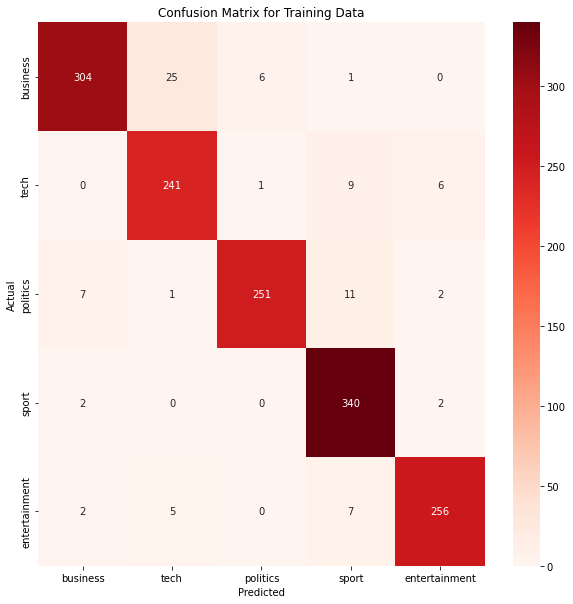

In [24]:
# Getting the labels of the categories
labels = BBC_train['Category'].unique()
y_pred = pd.DataFrame(y_train)

# plot confusion matrix
cm = confusion_matrix(BBC_train['Category'], y_pred[0].map(label_dict), labels=labels)

plt.figure(figsize=(10,10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds',xticklabels=labels, yticklabels=labels)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix for Training Data')
plt.show()

It looks like the highest misclassified article were business articles which were mistake for tech articles. This is actually makes a lot of sense with the state of our economy now and how intertwined business and technology topics often are. In its current state, the model's performance is acceptable to apply to the testing dataset and submit for the competition.

In [32]:
#prep test dataset
#dont clean testing dataset! it will lead to overfitting
tfv_test= tfv.transform(BBC_test['Text'])
best_nmf_clf.transform(tfv_test)
y_test = predict(best_nmf_clf.transform(tfv_test))



In [ ]:
#create new dataframe to submit to competition
test_pred = pd.DataFrame(columns = ['ArticleId','Category','y'])
test_pred['ArticleId'] = BBC_test['ArticleId']
test_pred['y'] = y_test
test_pred['Category'] = test_pred['y'].map(label_dict)

test_pred= test_pred.drop('y', axis = 1)
test_pred.head(10)

In [ ]:
try: 
    test_pred.to_csv('BBCclass_submission.csv', index=False)
except: 
    pass

The predicted testing file was uploaded to the kaggle testing competition and yielded an accuracy rating of 96.6% 
 
 ![picTitle](bbc_test_accuracy.png)


## Supervised Learning Model training and building 

Now we are going to train a supervised learning model and compare performance to the unsupervised learning model. We will still apply the TfidfVectorizer. I've chosen to implement support vector machines.

In [29]:
BBC_train_SML =pd.read_csv('BBC News Train.csv')
BBC_train_SML = cleanup_text(BBC_train_SML, 'Text')
tvf_sml = TfidfVectorizer(min_df = 0, max_df = 0.85, norm = 'l2', stop_words = 'english')
x = tvf_sml.fit_transform(BBC_train_SML['clean_text'])
y = BBC_train_SML['Category']

# Split the data into training and testing sets (80/20 split)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=101)

# Display the shape of the resulting feature matrices
x_train.shape, x_test.shape

((1192, 25039), (298, 25039))

In [30]:
from sklearn import svm


train_sizes = [0.1, 0.2, 0.5, 1.0]
eval_metrics = {'Training size':[],'Training set accuracy':[], 'Testing set accuracy':[]}

for item in train_sizes:
    train_size = int(item*x_train.shape[0])

    svc = svm.SVC(random_state=101)
    svc.fit(x_train[:train_size], y_train[:train_size])
    y_train_pred = svc.predict(x_train)
    y_test_pred = svc.predict(x_test)

    train_accuracy = accuracy_score(y_train, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)

    eval_metrics['Training size'].append(f'{item*100}%')
    eval_metrics['Training set accuracy'].append(f"{train_accuracy:.2%}")
    eval_metrics['Testing set accuracy'].append(f"{test_accuracy:.2%}")


eval_df = pd.DataFrame(eval_metrics)
eval_df

,Training size,Training set accuracy,Testing set accuracy
0,10.0%,83.31%,77.85%
1,20.0%,94.80%,94.63%
2,50.0%,96.98%,94.97%
3,100.0%,100.00%,96.31%


in this exercise of implementing a support vector machine classifier, only 20% of the training split (which is 80% of the original  data provided with labels) was required for acceptable accuracy.

It doesn't look like overfitting is too much of an issue even up to utilization of 100% of the training size. This was likely mitgated well because of the split of training and testing datasets.

Let's implement the trained model on the actual testing dataset and submit to the competition...

In [43]:
svc = svm.SVC(random_state=101)
# try only 20% and 50% of original 80% of training data
train_size = int(0.5*x_train.shape[0])
svc.fit(x_train[:train_size], y_train[:train_size])
#comment out above 2 lines and uncomment line below to run training on full training dataset.
#svc.fit(x, y)

tvf_sml_test = tvf_sml.transform(BBC_test['Text'])
y_test_sup = svc.predict(tvf_sml_test)

#create new dataframe to submit to competition
test_pred = pd.DataFrame(columns = ['ArticleId','Category'])
test_pred['ArticleId'] = BBC_test['ArticleId']
test_pred['Category'] = y_test_sup
#test_pred = test_pred['y'].map(label_dict)

#test_pred= test_pred.drop('y', axis = 1)
test_pred.head(10)

,ArticleId,Category
0,1018,sport
1,1319,tech
2,1138,sport
3,459,business
4,1020,sport
5,51,sport
6,2025,politics
7,1479,politics
8,27,entertainment
9,397,business


In [44]:
try: 
    test_pred.to_csv('BBCclass_submission_sup.csv', index=False)
except: 
    pass

With 100% of the training data utilized, I was able to get an accuracy rating of 98.2% which is highly accurate! With a reduction of the training data to 50% and 20%, I was still able to get an accuracy rating of 96% and 93.7% which is higher than the and similar to unsupervised model utilizing the full training dataset. Given this performance comparison, the supervised learning method was superior in terms of data efficiency.

20% of training data 
 ![20% of training data](bbc_sup_20.png)

 50% of training data
  ![50% of training data](bbc_sup_50.png)

100% of training data
 ![100% of training data](bbc_sup_100.png)

## Limitation(s) of sklearn’s non-negative matrix factorization library.

Next we will take a chance to explore the limitations of sklearn's non-negative matrix factorization library by implementing a NMF model on the movie ratings data.

In [48]:
#load in data
MV_users = pd.read_csv('users.csv')
MV_movies = pd.read_csv('movies.csv')
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

#preview dataframes
dfs = {"users":MV_users, "movies":MV_movies,"Training": train,"Testing": test}

for title, df in dfs.items():
    print("preview of", title)
    display(df.head())
    print("\n")

preview of users


,uID,gender,age,accupation,zip
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455




preview of movies


,mID,title,year,Doc,Com,Hor,Adv,Wes,Dra,Ani,...,Chi,Cri,Thr,Sci,Mys,Rom,Fil,Fan,Act,Mus
0,1,Toy Story,1995,0,1,0,0,0,0,1,...,1,0,0,0,0,0,0,0,0,0
1,2,Jumanji,1995,0,0,0,1,0,0,0,...,1,0,0,0,0,0,0,1,0,0
2,3,Grumpier Old Men,1995,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,4,Waiting to Exhale,1995,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Father of the Bride Part II,1995,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0




preview of Training


,uID,mID,rating
0,744,1210,5
1,3040,1584,4
2,1451,1293,5
3,5455,3176,2
4,2507,3074,5




preview of Testing


,uID,mID,rating
0,2233,440,4
1,4274,587,5
2,2498,454,3
3,2868,2336,5
4,1636,2686,5


In [49]:
# Finding the unique number of users and movies
unique_users = train['uID'].unique()
unique_movies = train['mID'].unique()

# Creating a new mapping from original user and movie IDs to connect to testing dataset
user_id_mapping = {uid: i for i, uid in enumerate(unique_users)}
#dict(enumerate(unique_users))
movie_id_mapping = {mid: i for i, mid in enumerate(unique_movies)}
#dict(enumerate(unique_movies))


# apply mapping to training and testing datasets
train['uID'] = train['uID'].apply(lambda uID: user_id_mapping[uID])
train['mID'] = train['mID'].apply(lambda mID: movie_id_mapping[mID])
test['uID'] = test['uID'].apply(lambda uID: user_id_mapping.get(uID))
test['mID'] = test['mID'].apply(lambda mID: movie_id_mapping.get(mID))

#create matrix the size of # of users by # of movies
rating_matrix = np.zeros((len(unique_users), len(unique_movies)))
for index, row in train.iterrows():
    rating_matrix[row['uID'], row['mID']] = row['rating']

pd.DataFrame(rating_matrix).iloc[:10, :10]


,0,1,2,3,4,5,6,7,8,9
0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0
1,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,4.0,0.0,5.0,4.0,0.0,0.0,0.0,0.0,3.0,0.0
3,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3.0,3.0,0.0,3.0,5.0,0.0,0.0,4.0,4.0,0.0
5,5.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,1.0
6,0.0,3.0,0.0,0.0,0.0,4.0,0.0,4.0,5.0,0.0
7,5.0,4.0,0.0,4.0,0.0,0.0,2.0,5.0,0.0,4.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0
9,0.0,2.0,0.0,0.0,5.0,0.0,0.0,3.0,3.0,0.0


In [50]:
#train NMF (non-negative matrix factorization)
feats = MV_movies.shape[1]-1
mov_nmf = NMF(n_components = feats, random_state= 101)
W = mov_nmf.fit_transform(rating_matrix)
H = mov_nmf.components_

#get predicted rating matrix
pred_rating_matrix = np.dot(W,H)
pd.DataFrame(pred_rating_matrix).iloc[:10, :10]

,0,1,2,3,4,5,6,7,8,9
0,4.414168,2.296680,0.264531,0.287094,0.316348,0.087709,0.271297,0.446441,0.321749,0.306868
1,0.590369,0.702372,0.043102,0.086480,0.000000,0.000000,0.000006,0.109248,0.005679,0.006859
2,3.591175,2.782772,2.705911,1.962264,1.292460,0.880703,0.299018,2.003230,1.107973,0.465519
3,2.882501,0.995809,0.264432,1.618092,0.000000,0.360811,0.052516,0.206151,1.203198,0.028518
4,2.200645,2.063167,1.899319,2.429974,0.746378,1.316971,0.093445,2.518317,1.801557,0.442708
5,3.310619,1.695576,3.194894,0.920318,1.430493,0.540691,0.222438,0.351835,0.114389,0.133881
6,1.024102,1.868404,0.331835,1.895384,0.000000,0.338657,0.580726,1.532863,1.567012,1.352864
7,1.650179,0.676401,1.309072,1.549393,0.307462,0.758830,0.212708,1.769011,1.432793,0.933992
8,3.169611,0.969887,0.300799,1.422684,0.211789,0.123433,0.383786,1.919201,1.428500,0.243504
9,1.024160,1.343574,1.246488,1.792947,0.422396,0.473077,0.527418,1.899663,1.742034,0.935446


In [51]:
y_true = test['rating'].values

def get_predicted_rating(uID, mID, predicted_ratings_matrix):
    if not np.isnan(uID) and not np.isnan(mID):
        return predicted_ratings_matrix[int(uID), int(mID)]
    else:
        return 0

y_pred = test.apply(lambda row: get_predicted_rating(row['uID'], row['mID'], pred_rating_matrix), axis=1)

# Calculate the RMSE
rmse = mean_squared_error(y_true, y_pred, squared=False)
round(rmse,4)

2.8609

The root mean square error (RMSE) for the predictions on the test set is approximately 2.8609. This value represents the average of the differences between the true ratings and the predicted ratings; a lower value would indicate more accurate predictions. This value is well over the typical acceptable range of 0.2-0.5 and therefore indicates this model does not perform well. 

The utilization of the non-negative matrix factorization library didn't work as well compared to simple baseline or similarity-based methods as practiced in week 3. Some of these reasons could include that similarity-based methods can help give Eigen vectors of the input matrix. This intermidiary matrix can give insights into the amount of information each eigen vector holds and provide better modeling of training data. These methods are deterministic and can allow for more predictable model behavior 

NMF splits a given matrix into the product of two matrices. It tries to get best fit decomposed matrices, which are trained on some training data and then done an evaluation on test data. It does not do very well in filling in missing values This method is more stochastic and allows for more randomness to makes its way to into the modeling. There may be opportunities to decrease the RMSE by tuning hyperparameters or trying out different initialization parameters. Another option would be to implement an NMF algorithim with improved population of missing values, since arbitrary assignment 

## References
1. Scikit-Learn Library Documentation
- [Scikit-Learn User Guide for NMF](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.NMF.html)
- [Scikit-Learn 1.4 Support Vector Machines](https://scikit-learn.org/stable/modules/svm.html#svm)
- [Scikit-Learn Method Documentation for TfidfVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html#sklearn.feature_extraction.text.TfidfVectorizer)
- [Scikit-Learn Method Documentation for CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html#sklearn.feature_extraction.text.CountVectorizer)
- [Scikit-Learn User Guide for Feature Extractio](https://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction)
2. Online Resources and Tutorials
Medium Articles, Stack Overflow threads, Kaggle, github, and various other online resources for implementing NMF.
